Homework 5
==========

In this homework...

- Use multivariate linear regression to predict molecular band gap energy from other molecular properties
- Analyze regression parameters with bootstrapping
- Assess goodness of fit of linear models


Problem statement
-----------------------
1. Data has been loaded in for you where independent variables are molecular volume, number of atoms, formation energy, and molecular stability. You will be predicting the band gap energy. Not all materials have band gaps. Remove all data points which have a value of 0 for the band gap energy. How many data points does that leave?


2. Standardize the remaining data. For every variable (independent and dependent), subtract the mean and divide the variance from every data point. Plot band gap energy vs. one of the independent variables of your choice.


3. Create a multi-variate linear regression model to predict the band gap energy from the other variables (molecular volume, number of atoms, formation energy, and molecular stability). Plot band gap energy vs. the same independent variable you plotted in question 2. Add a line of best fit for your selected covariate. Report the $R^2$ value of the regression model.


4. Perform bootstrapping on the multivariate regression problem and find histograms of the regression parameters (i.e., coefficients). If you use the bootstrapping function from discussion, you will need to edit it.
Bootstrapping requirements:
    - The number of bootstrapping samples per trial you use should be equal to the number of data points.
    - Use as many bootstrapping trials as you think are necessary.
    - Plot each histogram of regression parameters, on the same plot.
    - Plot the histograms by density (i.e., set `density=True` in the arguments of `plt.hist()`)


5. Clearly report the mean and variance of each histogram computed in part 4. Round each value to 4 decimal places.


6. Report the independent variable whose coefficient has the highest variance based on the bootstrapping histograms. Create a new multi-variate linear regression model to predict the band gap energy from the other variables $\textit{excluding}$ this high-variance variable. Recreate each plot from part 3 with the 3 remaining independent variables. Report the $R^2$ value of the regression model. What is the difference between this $R^2$ value and that in part 3? What does this suggest about the variable you removed?

Import the necessary modules

In [82]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
import random
from sklearn.utils import resample
import scipy.stats as st

Load data from the Open Quantum Materials Database: http://oqmd.org

Citations:
   - http://dx.doi.org/10.1007/s11837-013-0755-4
   - http://dx.doi.org/10.1038/npjcompumats.2015.10

Regression is done on all OQMD molecules containing both tungsten and nitrogen - about 250 molecules

In [83]:
# load data
data_list = []
for i in range(1,6):
    filename = 'formationenergy'+str(i)+'.json'
    with open(filename) as json_file:
        jfile = json.load(json_file)
        data_list = data_list + (jfile['data'])
df = pd.DataFrame(data_list)

# choose independent variables
indep_vars = ['volume','natoms','stability','delta_e']

# choose dependent variable
dep_var = 'band_gap'

# remove examples with missing values
xs = df[indep_vars].to_numpy()
xs = np.delete(xs,0,0)
ys = df[dep_var].to_numpy()
ys = np.delete(ys,0,0).reshape(-1,1)
all_data = np.concatenate((xs,ys),axis=1)
all_data  = all_data[~np.isnan(all_data).any(axis=1),:]
xs = all_data[:,:len(indep_vars)]
ys = all_data[:,-1]

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}

1. Data has been loaded in for you where independent variables are molecular volume, number of atoms, formation energy, and molecular stability. You will be predicting the band gap energy. Not all materials have band gaps. Remove all data points which have a value of 0 for the band gap energy. How many data points does that leave?

In [84]:
new_ys = ys[ys != 0]
new_xs = xs[ys != 0]

np.count_nonzero(new_ys, axis= None)

61

2. Standardize the remaining data. For every variable (independent and dependent), subtract the mean and divide the variance from every data point. Plot band gap energy vs. one of the independent variables of your choice.

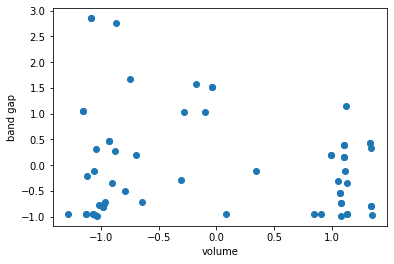

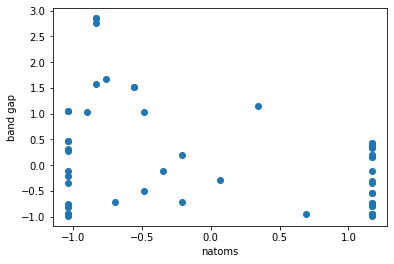

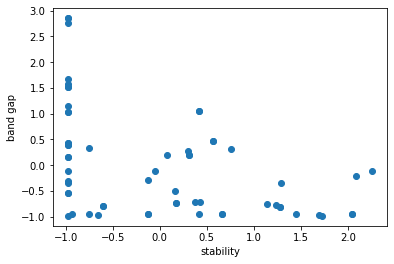

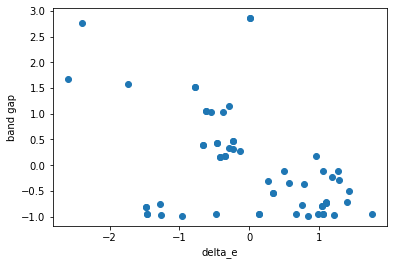

In [86]:
#standardize

ys_var = new_ys.var(axis=0)
ys_mean = new_ys.mean(axis=0)
ys_cen = (new_ys - ys_mean)/np.sqrt(ys_var)

xs_var = new_xs.var(axis=0)
xs_mean = new_xs.mean(axis=0)
xs_cen = (new_xs - xs_mean)/np.sqrt(xs_var)

for i in range(len(indep_vars)):
    plt.figure()
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    
    plt.scatter(xs_cen[:,i], ys_cen)
    plt.xlabel(indep_vars[i])
    plt.ylabel('band gap')
    plt.show()

3. Create a multi-variate linear regression model to predict the band gap energy from the other variables (molecular volume, number of atoms, formation energy, and molecular stability). Plot band gap energy vs. the same independent variable you plotted in question 2. Add a line of best fit for your selected covariate. Report the $R^2$ value of the regression model.

R^2 =  0.65072860553565


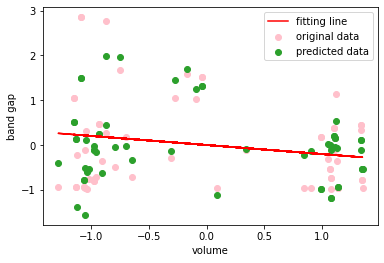

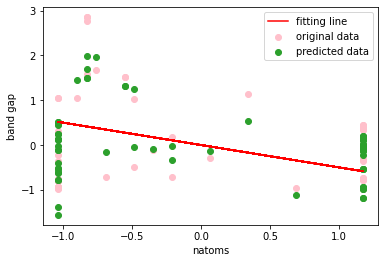

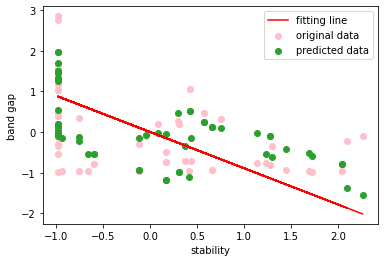

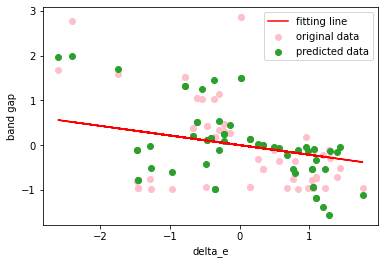

In [87]:
regr_model = linear_model.LinearRegression()
model = regr_model.fit(xs_cen, ys_cen)
predcit_ys = model.predict(xs_cen)
R2 = r2_score(ys_cen, predcit_ys)
print('R^2 = ', R2)

plt.figure()
for i in range(len(indep_vars)):
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    
    plt.scatter(xs_cen[:,i], ys_cen, label = 'original data',color = 'pink')
    plt.scatter(xs_cen[:,i], predcit_ys, label = 'predicted data',color = 'C2')
    
    model = regr_model.intercept_ + regr_model.coef_[i]*xs_cen[:,i]
    plt.plot(xs_cen[:,i], model, label = 'fitting line', color = 'r')
    
    plt.xlabel(indep_vars[i])
    plt.ylabel('band gap')
    plt.legend()
    plt.show()

4. Perform bootstrapping on the multivariate regression problem and find histograms of the regression parameters (i.e., coefficients). If you use the bootstrapping function from discussion, you will need to edit it.
Bootstrapping requirements:
    - The number of bootstrapping samples per trial you use should be equal to the number of data points.
    - Use as many bootstrapping trials as you think are necessary.
    - Plot each histogram of regression parameters, on the same plot.
    - Plot the histograms by density (i.e., set `density=True` in the arguments of `plt.hist()`)

In [88]:
def coef_booistrap(xs, ys, n_samples, n_boot):
    r"""
    Predict ys from xs

    Parameters
    ----------
    xs : 2D array
         independent variables of data
    ys : 1D array
         dependent variables of data 
    n_sample : int integer
               number of samples used for bootstrapping trails
    n_boota : int integer
              number of bootstrapping trails to run

    Returns
    -------
    coefs : list
            a list of coef value for each bootstrapping trail

    """
    a1 = []
    a2 = []
    a3 = []
    a4 = []
    
    for i in range(n_boot):
        inds = range(len(ys))
        boot = resample(inds, replace = True, n_samples = n_samples)
        sample_xs = xs[boot, :]
        sample_ys = ys[boot]
        regr_model = linear_model.LinearRegression()
        regr_model.fit(sample_xs, sample_ys)
        a1 = np.append(a1, regr_model.coef_[0])
        a2 = np.append(a2, regr_model.coef_[0])
        a3 = np.append(a3, regr_model.coef_[0])
        a4 = np.append(a4, regr_model.coef_[0])
        
    coefs = [a1, a2, a3, a4]
    return coefs

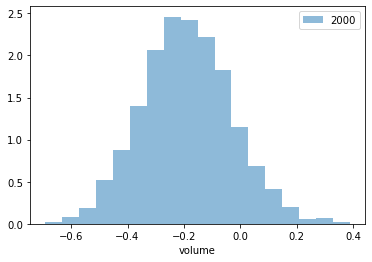

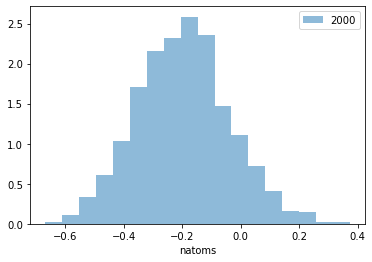

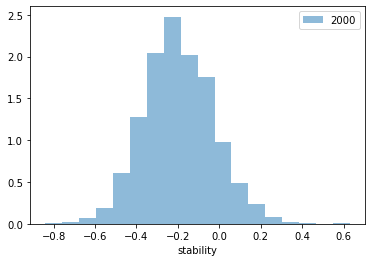

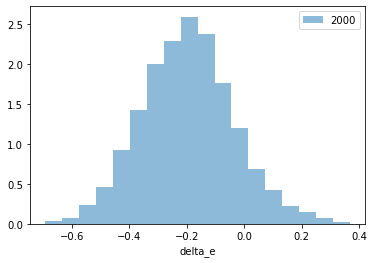

In [89]:
n_samples = len(ys)
n_boot = 2000

a_means = []
a_vars = []

for i in range(len(indep_vars)):
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    
    figure, ax = plt. subplots()
    coefs = coef_booistrap(xs_cen, ys_cen, n_samples, n_boot)
    ax.hist(coefs[i], 18, alpha = 0.5, label = str(n_boot), density = True)    
    a_mean = coefs[i].mean(axis = 0)
    a_var = coefs[i].var(axis = 0)
    a_means = np.append(a_means, a_mean)
    a_vars = np.append(a_vars, a_var)
    
    ax.set_xlabel(indep_vars[i])
    ax.legend()
    plt.show()

5. Clearly report the mean and variance of each histogram computed in part 4. Round each value to 4 decimal places.

In [90]:
for i in range(len(indep_vars)):
    print('mean for' + indep_vars[i] + ' = ' + f'{a_means[i]:.4f}')
    print('variance for' + indep_vars[i] + ' = ' + f'{a_vars[i]:.4f}')
    print('\n')

mean forvolume = -0.1897
variance forvolume = 0.0253


mean fornatoms = -0.1959
variance fornatoms = 0.0251


mean forstability = -0.1965
variance forstability = 0.0282


mean fordelta_e = -0.1956
variance fordelta_e = 0.0257




6. Report the independent variable whose coefficient has the highest variance based on the bootstrapping histograms. Create a new multi-variate linear regression model to predict the band gap energy from the other variables $\textit{excluding}$ this high-variance variable. Recreate each plot from part 3 with the 3 remaining independent variables. Report the $R^2$ value of the regression model. What is the difference between this $R^2$ value and that in part 3? What does this suggest about the variable you removed?

R^2 =  0.648284862514364


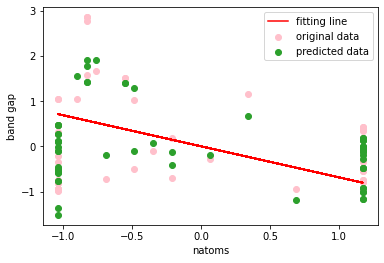

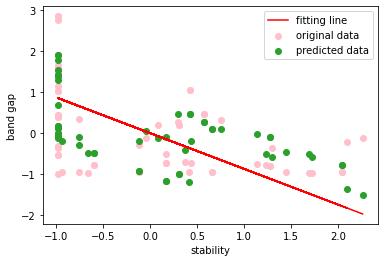

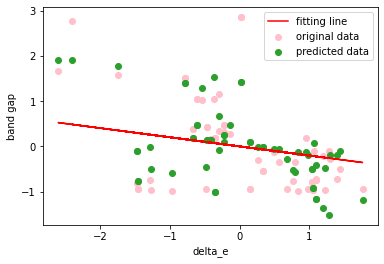

In [91]:
indep_vars = ['natoms','stability','delta_e']
dep_var = 'band_gap'

xs = df[indep_vars].to_numpy()
xs = np.delete(xs,0,0)
ys = df[dep_var].to_numpy()
ys = np.delete(ys,0,0).reshape(-1,1)
all_data = np.concatenate((xs,ys),axis=1)
all_data  = all_data[~np.isnan(all_data).any(axis=1),:]
xs = all_data[:,:len(indep_vars)]
ys = all_data[:,-1]

new_ys = ys[ys != 0]
new_xs = xs[ys != 0]

ys_var = new_ys.var(axis=0)
ys_mean = new_ys.mean(axis=0)
ys_cen = (new_ys - ys_mean)/np.sqrt(ys_var)

xs_var = new_xs.var(axis=0)
xs_mean = new_xs.mean(axis=0)
xs_cen = (new_xs - xs_mean)/np.sqrt(xs_var)

regr_model = linear_model.LinearRegression()
model = regr_model.fit(xs_cen, ys_cen)
predcit_ys = model.predict(xs_cen)
R2 = r2_score(ys_cen, predcit_ys)
print('R^2 = ', R2)

plt.figure()
for i in range(len(indep_vars)):
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    
    plt.scatter(xs_cen[:,i], ys_cen, label = 'original data',color = 'pink')
    plt.scatter(xs_cen[:,i], predcit_ys, label = 'predicted data',color = 'C2')
    
    model = regr_model.intercept_ + regr_model.coef_[i]*xs_cen[:,i]
    plt.plot(xs_cen[:,i], model, label = 'fitting line', color = 'r')
    
    plt.xlabel(indep_vars[i])
    plt.ylabel('band gap')
    plt.legend()
    plt.show()